# Прогнозирование оттока клиентов из «Бета-Банка»

Из «Бета-Банка» стали уходить клиенты. Отток клиентов небольшой на текущий момент, но уже заметен. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. Необходимо уметь делать прогноз по клиенту: уйдет ли он из банка в ближайшее время или нет.

**В данном проекте исследуется:** 
* Исторические данные о поведении клиентов «Бета-Банка», часть из которых уже перестали пользоваться услугами банка и растрогли договор.

**Цель проекта**: 
* Построить и обучить модель, которая сможет прогнозировать, уйдёт клиент из банка в ближайшее время;
* Метрика качества модели F1-мера должна быть не менее 0.59.

**Описание предоставленных данных**:
* `Churn.csv` - содержит инофрмацию о клиентах, такую как кредитный рейтинг, страна проживания, пол, возраст, оформлена ли кредитная карта, баланс на счете и другие данные. 

## Импорт библиотек

In [1]:
import pandas  as pd
import seaborn as sb
import numpy   as np

import matplotlib.pyplot     as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression 
from sklearn.ensemble        import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import f1_score
from sklearn.metrics         import recall_score
from sklearn.metrics         import precision_score
from sklearn.metrics         import accuracy_score 
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score 
from sklearn.metrics         import r2_score
from sklearn.utils           import shuffle
from sklearn.exceptions      import ConvergenceWarning

from scipy                   import stats
from warnings                import simplefilter

pd.set_option("max_columns", None)                 # show all cols
pd.set_option('max_colwidth', None)                # show full width of showing cols
pd.set_option("expand_frame_repr", False)          # print cols side by side as it's supposed to be
pd.options.display.float_format = '{:,.4f}'.format # pretty format for floats
pd.options.mode.chained_assignment = None          # ignore SettingWithCopy warning

sb.set(font_scale=0.8)                             # default font size on heatmaps was too big

In [2]:
# EDA-Анализ
# import sweetviz
# import pandas_profiling

## Загрузка данных

### Чтение данных

In [3]:
try:
    df = pd.read_csv('datasets/Churn.csv', sep=',')
    print('Данные загружены из локальной папки.')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv', sep=',')
    print('Данные загружены из сети.')

Данные загружены из локальной папки.


### Общая информация о представленном датасете

In [4]:
def show_info(data, full=True):
    print('Первые пять строк:')
    display(data.head(5))
    if full:
        print('Описательная статистика:')
        display(data.describe())
        print('Информация по столбцам:')
        data.info()
        print("\nЧисло явных дубликатов:", data.duplicated().sum())
        print("Число пропусков:", data.isna().sum().sum())

In [5]:
show_info(df)

Первые пять строк:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0000,0.0000,1,1,1,"101,348.8800",1
1,2,15647311,Hill,608,Spain,Female,41,1.0000,"83,807.8600",1,0,1,"112,542.5800",0
2,3,15619304,Onio,502,France,Female,42,8.0000,"159,660.8000",3,1,0,"113,931.5700",1
3,4,15701354,Boni,699,France,Female,39,1.0000,0.0000,2,0,0,"93,826.6300",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0000,"125,510.8200",1,1,1,"79,084.1000",0


Описательная статистика:


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,"10,000.0000","10,000.0000","10,000.0000","10,000.0000","9,091.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000","10,000.0000"
mean,"5,000.5000","15,690,940.5694",650.5288,38.9218,4.9977,"76,485.8893",1.5302,0.7055,0.5151,"100,090.2399",0.2037
std,"2,886.8957","71,936.1861",96.6533,10.4878,2.8947,"62,397.4052",0.5817,0.4558,0.4998,"57,510.4928",0.4028
min,1.0000,"15,565,701.0000",350.0000,18.0000,0.0000,0.0000,1.0000,0.0000,0.0000,11.5800,0.0000
25%,"2,500.7500","15,628,528.2500",584.0000,32.0000,2.0000,0.0000,1.0000,0.0000,0.0000,"51,002.1100",0.0000
50%,"5,000.5000","15,690,738.0000",652.0000,37.0000,5.0000,"97,198.5400",1.0000,1.0000,1.0000,"100,193.9150",0.0000
75%,"7,500.2500","15,753,233.7500",718.0000,44.0000,7.0000,"127,644.2400",2.0000,1.0000,1.0000,"149,388.2475",0.0000
max,"10,000.0000","15,815,690.0000",850.0000,92.0000,10.0000,"250,898.0900",4.0000,1.0000,1.0000,"199,992.4800",1.0000


Информация по столбцам:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB

Число явных дубликатов: 0
Число пропусков: 909


### Выводы по разделу

Для выполнения проекта представлены исторические данные о поведении клиентов и расторжении договоров с банком. Датасет содержит 10000 строк (явные дубликаты отсутствуют) и следующие столбцы:

* `RowNumber` — индекс строки в данных, нет пропусков;
* `CustomerId` — уникальный идентификатор клиента, нет пропусков;
* `Surname` — фамилия, нет пропусков;
* `CreditScore` — кредитный рейтинг, нет пропусков;
* `Geography` — страна проживания, нет пропусков;
* `Gender` — пол, нет пропусков;
* `Age` — возраст, нет пропусков;
* `Tenure` — сколько лет человек является клиентом банка, **есть пропуски**;
* `Balance` — баланс на счёте;
* `NumOfProducts` — количество продуктов банка, используемых клиентом, нет пропусков;
* `HasCrCard` — наличие кредитной карты, нет пропусков;
* `IsActiveMember` — активность клиента, нет пропусков;
* `EstimatedSalary` — предполагаемая зарплата, нет пропусков;
* `Exited` — факт ухода клиента, нет пропусков;

## Предобработка данных

### Неявные дубликаты

Выполним проверку, что все значения `CustomerId` являются уникальными, чтобы исключить возможность наличия неявных дубликатов по клиентам вследствие какой-либо ошибки при выгрузке данных:

In [6]:
try:
    print('Число уникальных CustomerId:',df['CustomerId'].nunique())
except:
    print('Столбец не найден...')

Число уникальных CustomerId: 10000


Также проверим наличие неявных дубликатов, пропусков или аномальных значений в категориальных столбцах:

In [7]:
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].unique()}")

Surname: ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']
Geography: ['France' 'Spain' 'Germany']
Gender: ['Female' 'Male']


Уникальные значения в столбцах `Geography` и `Gender` корректны. Значения в столбце `Surname` неважны, т.к. вряд ли этот признак будет полезен при обучении модели.

### Очистка неактуальной информации

Удалим из датафрейма признаки, которые скорее всего не будут полезны при обучении модели:

In [8]:
try:
    df = df.drop(['RowNumber','CustomerId','Surname'],axis=1)
except:
    print('Столбцы уже удалены...')

### Пропуски

In [9]:
print("Пропуски в датасете:")
print(df.isna().sum())

Пропуски в датасете:
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


Пропуски обнаружены только в столбце `Tenure`. Проверим как распределено это значение в датасете, с какими другими значениями оно может коррелировать, чтобы определить варианты заполнения пропусков.  

In [10]:
# Функция для создания названий осей и заголовка графиков
def show_plot_labels(title, xlabel, ylabel):
    plt.title(title)
    if xlabel != '':
        plt.xlabel(xlabel)
    if ylabel != '':
        plt.ylabel(ylabel)
    plt.show() 

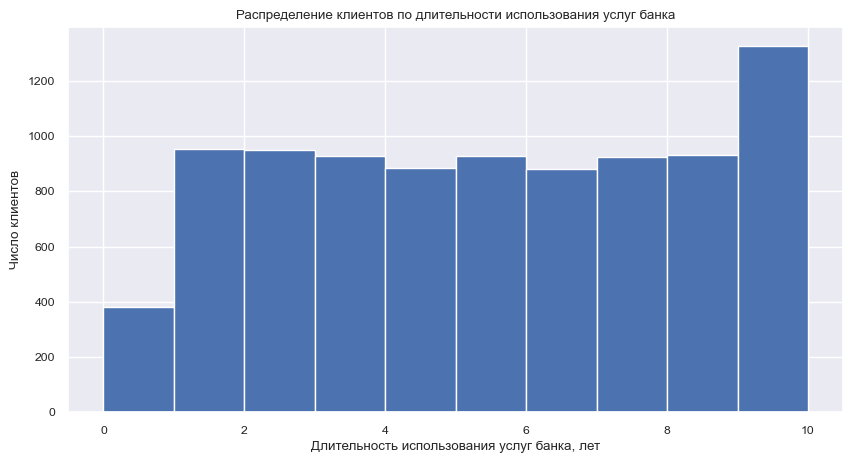

In [11]:
df['Tenure'].hist(figsize=(10,5))
show_plot_labels('Распределение клиентов по длительности использования услуг банка','Длительность использования услуг банка, лет','Число клиентов')

In [12]:
df.corr()['Tenure'].sort_values(ascending=False)

Tenure             1.0000
HasCrCard          0.0272
NumOfProducts      0.0120
EstimatedSalary    0.0105
CreditScore       -0.0001
Balance           -0.0079
Age               -0.0131
Exited            -0.0168
IsActiveMember    -0.0322
Name: Tenure, dtype: float64

In [13]:
display(df.pivot_table(index=['Gender','Geography'],values='Tenure',aggfunc='median'))

Tenure
Gender Geography        
Female France     5.0000
       Germany    5.0000
       Spain      5.0000
Male   France     5.0000
       Germany    5.0000
       Spain      5.0000

Установлено, что медианное значение `Tenure` равно `5ти` годам. Явной связи с другими признаками не наблюдается. 

Заполнить пропуски можно следующими путями:
1. Заполнить медианным значением;
2. Восстановить пропуски по [исходному датасету](https://www.kaggle.com/datasets/barelydedicated/bank-customer-churn-modeling);

3. Удалить строки с пропусками, т.к. их менее 10% от всего датасета.

Однако в целях обучения и исследования попробуем пойти другим путем: создадим и обучим модель, которая сможет предсказывать значение `Tenure`. Далее заполним пропуски с помощью этой модели.  

In [14]:
if (df.isna().sum().sum()>0):
    df_tenure = df.dropna()

df_tenure_ohe      = pd.get_dummies(df_tenure, drop_first=True)
df_tenure_features = df_tenure_ohe.drop(['Tenure'], axis=1)
df_tenure_target   = df_tenure_ohe['Tenure']

tenure_features_train, tenure_features_valid, tenure_target_train, tenure_target_valid = train_test_split(df_tenure_features, df_tenure_target, test_size=0.2, random_state=12345)

grid = GridSearchCV(RandomForestRegressor(random_state=1234257), {'max_depth': range(1,5,1), 'n_estimators': range(1,10,1)}, n_jobs=-1, scoring='r2')
grid.fit(tenure_features_train, tenure_target_train)

tenure_model = grid.best_estimator_
predicted_valid = tenure_model.predict(tenure_features_valid)

print("RandomForestRegressor Model для заполнения пропусков в столбце Tenure")
print('Подобранные гиперпараметры:', grid.best_params_)
print('R2=',r2_score(tenure_target_valid,predicted_valid))

RandomForestRegressor Model для заполнения пропусков в столбце Tenure
Подобранные гиперпараметры: {'max_depth': 1, 'n_estimators': 4}
R2= 0.000544198882389102


`R2 метрика` обученной модели практически равна `0`. Это означает, что MSE модели не выше чем MSE среднего значения. Но формально R2 не отрицательное и для исследования будем далее заполнять пропуски с помощью модели.

*Комментарий*:
В процессе работы над проектом пропуски были заполнены и с помощью медианы, и минимальным значением `0`, и также удалялись из датасета. Однако, предложенный выше механизм показал немного лучший результат по целевой F1-метрике.  


In [15]:
df_ohe = pd.get_dummies(df, drop_first=True)

df_tenure_features = df_ohe.drop(['Tenure'], axis=1)
df['Tenure_Predicted'] = tenure_model.predict(df_tenure_features)
df.loc[df['Tenure'].isna(),'Tenure'] = df.loc[df['Tenure'].isna(),'Tenure_Predicted']
df = df.drop(['Tenure_Predicted'], axis=1)

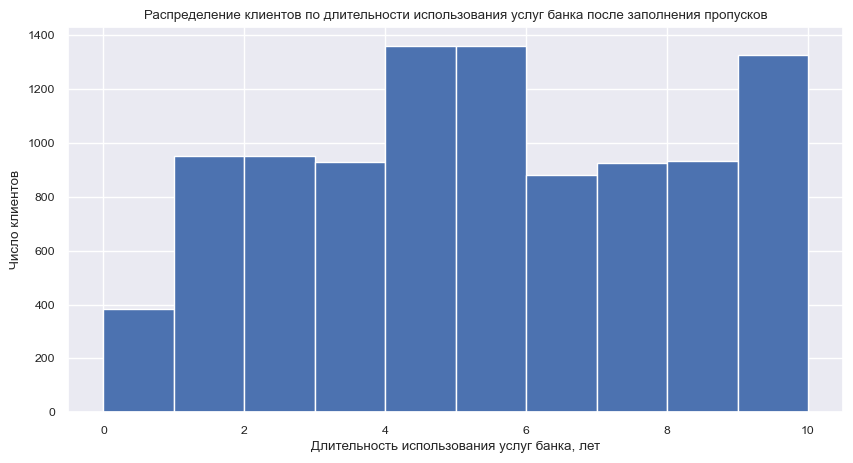

In [16]:
df['Tenure'].hist(figsize=(10,5))
show_plot_labels('Распределение клиентов по длительности использования услуг банка после заполнения пропусков','Длительность использования услуг банка, лет','Число клиентов')

### Аномальные значения

Определим выбросы в количественных признаках, т.к. аномальные значения могут негативно сказаться на обучении модели.

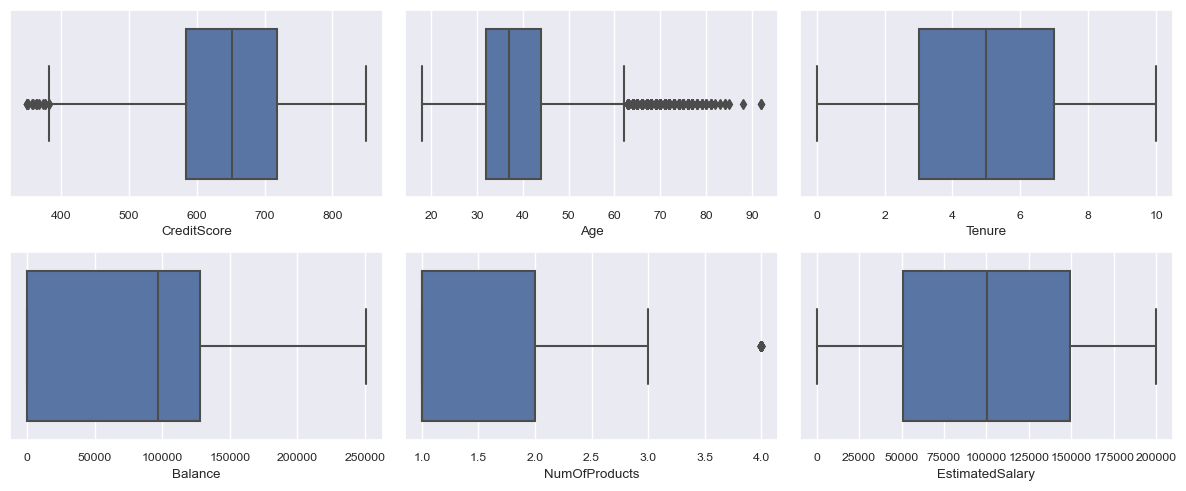

In [17]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts','EstimatedSalary']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 5))
axs = axs.flatten()

for i, var in enumerate(numeric):
    sb.boxplot(x=var, data=df, ax=axs[i])

fig.tight_layout()
plt.show()

Выбросы зафиксированы в столбцах `CreditScore`, `Age` и `NumOfProducts`. Это будет учтено при построении обучающей выборки далее.

### Выводы по разделу

* В датасете не обнаружены неявные дубликаты;

* Столбцы `RowNumber`, `CustomerId`, `Surname` удалены из датасета, т.к. не будут полезны для обучения модели;

* В столбце `Tenure` обнаружены пропуски. Для их заполнения построена и обучена регрессионная модель, которая прогнозирует значение `Tenure` для клиента. R2-метрика модели положительная, но к сожалению близка к 0. Модель предсказывает значения довольно близкие к медианному значению столбца `5 лет`. Однако распределение клиентов по длительности использования услуг банка оказывается более равномерным в области 4-6 лет, нежели при заполнении пропусков медианным или средним значением.

* В столбцах `CreditScore`, `Age` и `NumOfProducts` обнаружены аномальные значения. Эти значения будут удалены при построении обучающей выборки. 


## Создание обучающей, валидационной и тестовой выборок

### Кодирование категориальных признаков

In [18]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0000,0.0000,1,1,1,"101,348.8800",1,0,0,0
1,608,41,1.0000,"83,807.8600",1,0,1,"112,542.5800",0,0,1,0
2,502,42,8.0000,"159,660.8000",3,1,0,"113,931.5700",1,0,0,0
3,699,39,1.0000,0.0000,2,0,0,"93,826.6300",0,0,0,0
4,850,43,2.0000,"125,510.8200",1,1,1,"79,084.1000",0,0,1,0


### Подготовка признаков и целевого признака

In [19]:
df_features = df_ohe.drop('Exited', axis=1)
df_target   = df_ohe['Exited']

### Разбиение датасета на выборки

Разбиение датасета на обучающую, валидационную и тестовую выборку будет в пропорции 3:1:1.

In [20]:
rnd_seed = 24092010
print('Random Seed установлен:', rnd_seed)

Random Seed установлен: 24092010


In [21]:
class Features:
    def __init__(self):
        self.train             = pd.DataFrame()
        self.train_upsampled   = pd.DataFrame()
        self.train_downsampled = pd.DataFrame()
        self.validation        = pd.DataFrame()
        self.test              = pd.DataFrame()

class Target:
    def __init__(self):
        self.train             = pd.DataFrame()
        self.train_upsampled   = pd.DataFrame()
        self.train_downsampled = pd.DataFrame()
        self.validation        = pd.DataFrame()
        self.test              = pd.DataFrame()

In [22]:
features = Features()
target   = Target()

df_features_part, features.test, df_target_part, target.test = train_test_split(df_features, df_target, test_size=0.2, random_state=rnd_seed)
features.train, features.validation, target.train, target.validation = train_test_split(df_features_part, df_target_part, test_size=0.25, random_state=rnd_seed)

In [23]:
print ('Все параметры:\t\t', df_features.shape, '\t', df_target.shape)
print ('Обучающая выборка:\t', features.train.shape,'\t', target.train.shape)
print ('Валидационная выборка:\t',features.validation.shape,'\t', target.validation.shape)
print ('Тестовая выборка:\t',features.test.shape,'\t', target.test.shape)

Все параметры:		 (10000, 11) 	 (10000,)
Обучающая выборка:	 (6000, 11) 	 (6000,)
Валидационная выборка:	 (2000, 11) 	 (2000,)
Тестовая выборка:	 (2000, 11) 	 (2000,)


Размерность получившихся выборок корректна.

### Удаление аномальных значений из обучающей выборки

In [24]:
columns = ['Age', 'NumOfProducts','CreditScore']
z_scores = np.abs(stats.zscore(features.train[columns]))
threshold = 3

indices_to_delete = np.where(z_scores > threshold)[0]
print (f'Будет удалено {len(indices_to_delete)} аномальных значений.')

features.train = features.train.drop(features.train.index[indices_to_delete])
target.train = target.train.drop(target.train.index[indices_to_delete])

Будет удалено 117 аномальных значений.


### Масштабирование признаков

При выборе модели будет использоваться в том числе `Логистическая регрессия`. Поэтому для корректного обучения необходимо выполнить масштабирование количественных признаков.

In [25]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance','NumOfProducts','EstimatedSalary']
features.train.head(5)

scaler = StandardScaler()
scaler.fit(features.train[numeric])
features.train[numeric] = scaler.transform(features.train[numeric])
features.validation[numeric] = scaler.transform(features.validation[numeric])
features.test[numeric] = scaler.transform(features.test[numeric])

In [26]:
display(features.train.head(3))
display(features.validation.head(3))
display(features.test.head(3))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
1447,0.4739,1.8365,-0.0569,0.5507,-0.9251,1,1,-0.8585,0,1,1
3593,-0.9967,2.4610,1.8174,0.6153,-0.9251,0,1,-1.5839,1,0,0
1695,-1.5041,-0.4533,0.7201,-1.2286,0.8988,0,0,0.2804,0,0,1


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9136,-0.5824,-1.9105,-0.3772,0.3103,-0.9251,1,0,1.3549,0,0,1
2567,-1.0174,0.3794,-1.4744,-1.2286,0.8988,0,0,-1.3170,0,0,1
5725,-1.4938,-0.5574,-1.4744,0.5933,-0.9251,0,0,0.7503,0,0,0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7251,0.7535,-0.7655,0.0293,0.9901,-0.9251,1,0,-1.5062,1,0,1
3182,0.1839,0.4835,-1.4744,1.3484,-0.9251,1,1,-0.0647,0,0,0
9695,0.6085,-0.1410,-0.0229,0.9521,-0.9251,0,1,-0.9229,1,0,1


### Исследование баланса классов

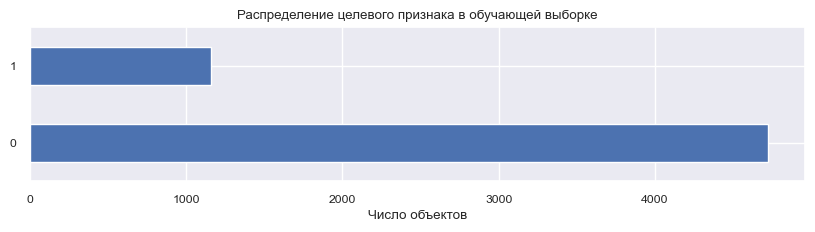

Всего объектов в обучающей выборке: 5883
... Положительных классов: 1158
... Отрицательных классов: 4725
... Соотношение классов: 0.2450793650793651


In [27]:
target.train.to_frame()['Exited'].value_counts().plot.barh(figsize=(10,2))
show_plot_labels('Распределение целевого признака в обучающей выборке','Число объектов','')

classes_total = len(target.train)
classes_positive = target.train.sum()
classes_negative = classes_total - classes_positive
print ('Всего объектов в обучающей выборке:', classes_total)
print ('... Положительных классов:', classes_positive)
print ('... Отрицательных классов:', classes_negative)
print ('... Соотношение классов:', classes_positive/classes_negative)

В датасете сильный дисбаланс классов. Для изучения методов борьбы с дисбалансом создадим увеличенную и уменьшенную обучающую выборки.

In [28]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones  = features[target == 1]
    target_zeros   = target[target == 0]
    target_ones    = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=rnd_seed)
    
    return features_upsampled, target_upsampled

features.train_upsampled, target.train_upsampled = upsample(features.train, target.train, 4)

In [29]:
classes_total = len(target.train_upsampled)
classes_positive = target.train_upsampled.sum()
classes_negative = classes_total - classes_positive
print ('Всего объектов в обучающей выборке train_upsampled:', classes_total)
print ('... Положительных классов:', classes_positive)
print ('... Отрицательных классов:', classes_negative)
print ('... Соотношение классов:', classes_positive/classes_negative)

Всего объектов в обучающей выборке train_upsampled: 9357
... Положительных классов: 4632
... Отрицательных классов: 4725
... Соотношение классов: 0.9803174603174604


In [30]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones  = features[target == 1]
    target_zeros   = target[target == 0]
    target_ones    = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=rnd_seed)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=rnd_seed)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=rnd_seed)
    
    return features_downsampled, target_downsampled

features.train_downsampled, target.train_downsampled = downsample(features.train, target.train, 0.25)

In [31]:
classes_total = len(target.train_downsampled)
classes_positive = target.train_downsampled.sum()
classes_negative = classes_total - classes_positive
print ('Всего объектов в обучающей выборке train_downsampled:', classes_total)
print ('... Положительных классов:', classes_positive)
print ('... Отрицательных классов:', classes_negative)
print ('... Соотношение классов:', classes_positive/classes_negative)

Всего объектов в обучающей выборке train_downsampled: 2339
... Положительных классов: 1158
... Отрицательных классов: 1181
... Соотношение классов: 0.9805249788314987


### Выводы по разделу

* Для обучения модели в качестве целевого признака выбрано значение столбца `Exited`;

* Датасет разбит на три выборки в пропорции `3:1:1` - обучающая (5883 наблюдений), валидационная (2000 наблюдения) и тестовая (2000 наблюдений).

* В обучающей выборке обнаружен дисбаланс классов приблизительно в пропорции `5:1`. Для исследования методов подавления дисбаланса построены увеличенная и уменьшенная обучающая выборка, в которых пропорция классов близка к `1:1`.

* К обучающей выборке применен механизм масштабирования количественных признаков и OHE кодирование категориальных признаков.

* Произведена очистка обучающей выборки от аномальных значений признаков `Age`, `NumOfProducts` и `CreditScore`.

## Построение, обучение и выбор модели

Для выбора лучшей модели будет применен следующий алгоритм:
1.	Будут исследованы классификаторы: `Решающее дерево`, `Случайный лес` и `Логистическая регрессия`. 

2.	 Каждый классификатор будет обучаться на выборке с дисбалансом классов, на увеличенной выборке, на уменьшенной выборке, а также с взвешиванием классов.

3.	Для каждой комбинации классификатора и обучающей выборки будут подбираться оптимальные гипер-параметры с помощью модуля `GridSearchCV` или с помощью простого перебора.

4.	Для каждого классификатора будет определена модель, которая показывает максимальную F1-метрику на валидационной выборке.

5.	Далее будет выбран классификатор, с помощью которого построена модель с максимальной F1-метрикой на валидационной выборке. 

In [32]:
# Функция подбирает оптимальные гипер-параметры
# и вычисляет основные метрики модели на тестовой и валидационных выборках
# ------------------------------------------------------------------------
# classifier      - классификатор
# parameters      - диапазон гипер-параметров для поиска лучшей модели
# features_t      - признаки обучающей выборки
# target_t        - целевой признак обучающий выборкиэ
# features_v      - признаки валидационной выборки
# target_v        - целевой признак валидационной выборки
# description     - описание
# use_grid_search - использовать или нет кросс-валидацию при обучении и поиске гипер-параметров

def get_model_score(classifier, parametrs, features_t, target_t, features_v, target_v, description, use_grid_search):
    
    if use_grid_search:
        grid = GridSearchCV(classifier, parametrs, n_jobs=-1, scoring="f1")
        grid.fit(features_t, target_t)
        best_model  = grid.best_estimator_
        best_params = grid.best_params_
    else:
        best_f1 = 0
        try:
            class_weight = parametrs['class_weight'][0]
        except:
            class_weight = None  
        if type(classifier) == type(LogisticRegression()):
            for cur_solver in parametrs['solver']:
                for cur_c in parametrs['C']:
                    for iter in parametrs['max_iter']:
                        model = LogisticRegression(random_state=rnd_seed,max_iter=iter,C=cur_c,solver=cur_solver,class_weight=class_weight)
                        model.fit(features_t, target_t)
                        f1 = f1_score(target.validation, model.predict(features.validation))
                        if (f1 > best_f1):
                            best_f1 = f1
                            best_model = model
                            best_params = {'C': cur_c, 'max_iter': iter, 'solver': cur_solver, 'random_state': rnd_seed, 'class_weight': class_weight} 
        elif type(classifier) == type(DecisionTreeClassifier()):
            for depth in parametrs['max_depth']:
                model = DecisionTreeClassifier(random_state=rnd_seed,max_depth=depth,class_weight=class_weight)
                model.fit(features_t, target_t)
                f1 = f1_score(target.validation, model.predict(features.validation))
                if (f1 > best_f1):
                    best_f1 = f1
                    best_model = model
                    best_params = {'max_depth': depth, 'random_state': rnd_seed, 'class_weight': class_weight}
        elif type(classifier) == type(RandomForestClassifier()):   
            for est in parametrs['n_estimators']:
                for depth in parametrs['max_depth']:
                    model = RandomForestClassifier(random_state=rnd_seed,max_depth=depth,n_estimators=est,class_weight=class_weight)
                    model.fit(features_t, target_t)
                    f1 = f1_score(target.validation, model.predict(features.validation))
                    if (f1 > best_f1):
                        best_f1 = f1
                        best_model = model
                        best_params = {'max_depth': depth, 'n_estimators': est, 'random_state': rnd_seed, 'class_weight': class_weight}
        else:
            raise Exception("Unknown classifier")

    accuracy = [
        accuracy_score(target_t, best_model.predict(features_t)),
        accuracy_score(target_v, best_model.predict(features_v))
    ]
    precision = [
        precision_score(target_t, best_model.predict(features_t)),
        precision_score(target_v, best_model.predict(features_v))
    ]
    recall = [
        recall_score(target_t, best_model.predict(features_t)),
        recall_score(target_v, best_model.predict(features_v))
    ]
    f1 = [
        f1_score(target_t, best_model.predict(features_t)),
        f1_score(target_v, best_model.predict(features_v))
    ]
    roc_auc = [
        roc_auc_score(target_t, best_model.predict_proba(features_t)[:,1]),
        roc_auc_score(target_v, best_model.predict_proba(features_v)[:,1])
    ]
    # Таблица основных метрик
    metrics_table = pd.DataFrame([accuracy,precision,recall,f1,roc_auc], index=['Accuracy','Precision','Recall','F1-Score','ROC-AUC'], columns=['Train', 'Validation'])
    
    # Вычисление ROC-Curve
    fpr, tpr, thresholds = roc_curve(target_v, best_model.predict_proba(features_v)[:,1])

    # Определение порога классификации для лучшей F1-Score
    probabilities_v = best_model.predict_proba(features_v)
    probabilities_positive_v = probabilities_v[:, 1]
    best_f1 = -1
    best_threshold = -1
    for threshold in thresholds:
        predicted_v = probabilities_positive_v > threshold
        current_f1 = f1_score(target_v, predicted_v)
        if (current_f1 > best_f1):
            best_f1 = current_f1
            best_threshold = threshold

    # Отображение ROC-Curve
    plt.figure(figsize=(8, 4))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.text(0.5,0.05, str(best_params), bbox = dict(facecolor = 'white', alpha = 0.25), fontsize = 8, horizontalalignment='center')
    show_plot_labels(description + '\nROC-кривая для валидационной выборки.','False Positive Rate','True Positive Rate')

    # Сводная информация по модели
    print('Классификатор:', classifier)
    print(description)
    print('\nПодобранные гиперпараметры:', best_params)
    print('Использование кросс-валидации при обучении:', use_grid_search)
    print(f'\nДля валидационной выборки достигнута максимальная F1-мера {best_f1:.3f} при пороге {best_threshold:.3f}.')
    print('Основные метрики:')
    display(metrics_table)
    print ('*' * 91 + '\n')

    return best_model, best_params, f1[1], best_threshold

In [33]:
# Функция проводит тестирование набора моделей, 
# с различными обучающими выборками, свойствами и наборами гипер-параметров
# --------------------------------------------------------------------------
# Возвращает: параметры модели, которая показала лучшую F1-меру на валидационной выборке

def test_models_set(models_to_test):
    set_best_f1 = -1
    for model in models_to_test:
        (best_model, best_params, best_f1, best_threshold) = get_model_score(
            classifier      = model['classifier'],
            description     = model['description'],
            parametrs       = model['parametrs'],
            features_t      = model['features_t'],
            target_t        = model['target_t'],
            features_v      = features.validation,
            target_v        = target.validation, 
            use_grid_search = model['use_grid_search']           
        )

        if (best_f1 > set_best_f1):
            set_best_f1 = best_f1
            set_best_model = best_model
            set_best_model_params = best_params
            set_best_model_threshold = best_threshold
            set_best_model_description = model['description']
    
    return set_best_model, set_best_model_params, set_best_f1, set_best_model_threshold, set_best_model_description

### Решающее дерево

In [34]:
models_to_test = [
    {
        'classifier'      : DecisionTreeClassifier(),
        'description'     :'Решающее дерево, без учета дисбаланса классов. Используется кросс-валидация.',
        'parametrs'       : {'max_depth': range(1,25,1), 'criterion': ['gini','entropy'], 'random_state':[rnd_seed]},
        'features_t'      : features.train,
        'target_t'        : target.train,
        'use_grid_search' : True
    },
    {
        'classifier'      : DecisionTreeClassifier(),
        'description'     :'Решающее дерево, используется взвешивание классов. Используется кросс-валидация.',
        'parametrs'       : {'max_depth': range(1,25,1), 'criterion': ['gini','entropy'], 'random_state':[rnd_seed], 'class_weight':['balanced']},
        'features_t'      : features.train,
        'target_t'        : target.train,
        'use_grid_search' : True
    },
     {
        'classifier'      : DecisionTreeClassifier(),
        'description'     :'Решающее дерево, используется взвешивание классов. Кросс-валидация не используется.',
        'parametrs'       : {'max_depth': range(1,25,1), 'criterion': ['gini','entropy'], 'random_state':[rnd_seed], 'class_weight':['balanced']},
        'features_t'      : features.train,
        'target_t'        : target.train,
        'use_grid_search' : False
    },
    {
        'classifier'      : DecisionTreeClassifier(),
        'description'     :'Решающее дерево, используется увеличенная обучающая выборка. Кросс-валидация не используется.',
        'parametrs'       : {'max_depth': range(1,25,1), 'criterion': ['gini','entropy'], 'random_state':[rnd_seed]},
        'features_t'      : features.train_upsampled,
        'target_t'        : target.train_upsampled,
        'use_grid_search' : False
    },
    {
        'classifier'       : DecisionTreeClassifier(),
        'description'      :'Решающее дерево, используется уменьшенная обучающая выборка. Кросс-валидация не используется.',
        'parametrs'        : {'max_depth': range(1,25,1), 'criterion': ['gini','entropy'], 'random_state':[rnd_seed]},
        'features_t'       : features.train_downsampled,
        'target_t'         : target.train_downsampled,
         'use_grid_search' : False
    }
]

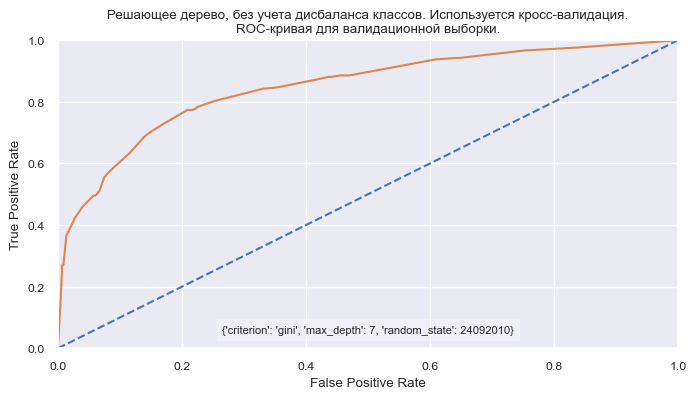

Классификатор: DecisionTreeClassifier()
Решающее дерево, без учета дисбаланса классов. Используется кросс-валидация.

Подобранные гиперпараметры: {'criterion': 'gini', 'max_depth': 7, 'random_state': 24092010}
Использование кросс-валидации при обучении: True

Для валидационной выборки достигнута максимальная F1-мера 0.622 при пороге 0.250.
Основные метрики:


,Train,Validation
Accuracy,0.8769,0.8560
Precision,0.8288,0.7727
Recall,0.4724,0.4452
F1-Score,0.6018,0.5650
ROC-AUC,0.8827,0.8478


*******************************************************************************************



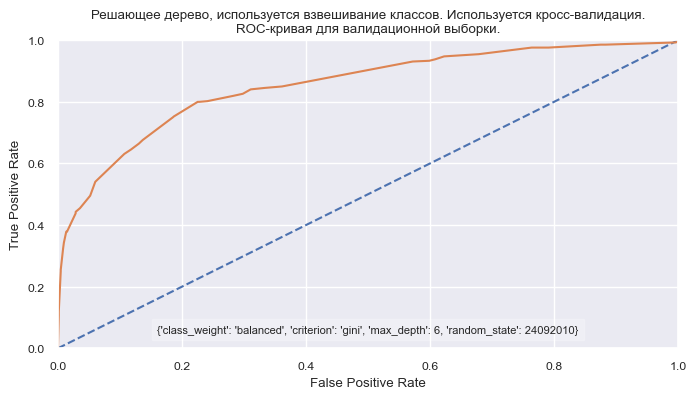

Классификатор: DecisionTreeClassifier()
Решающее дерево, используется взвешивание классов. Используется кросс-валидация.

Подобранные гиперпараметры: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'random_state': 24092010}
Использование кросс-валидации при обучении: True

Для валидационной выборки достигнута максимальная F1-мера 0.621 при пороге 0.646.
Основные метрики:


,Train,Validation
Accuracy,0.8037,0.8005
Precision,0.5008,0.5172
Recall,0.7642,0.7524
F1-Score,0.6051,0.6130
ROC-AUC,0.8696,0.8528


*******************************************************************************************



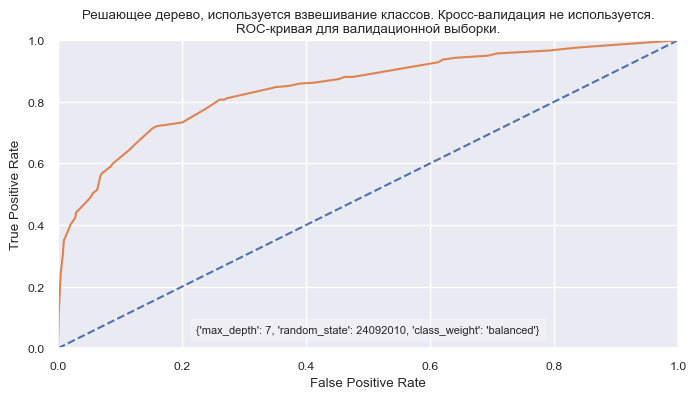

Классификатор: DecisionTreeClassifier()
Решающее дерево, используется взвешивание классов. Кросс-валидация не используется.

Подобранные гиперпараметры: {'max_depth': 7, 'random_state': 24092010, 'class_weight': 'balanced'}
Использование кросс-валидации при обучении: False

Для валидационной выборки достигнута максимальная F1-мера 0.624 при пороге 0.605.
Основные метрики:


,Train,Validation
Accuracy,0.8339,0.8180
Precision,0.5581,0.5513
Recall,0.7513,0.7167
F1-Score,0.6404,0.6232
ROC-AUC,0.8895,0.8456


*******************************************************************************************



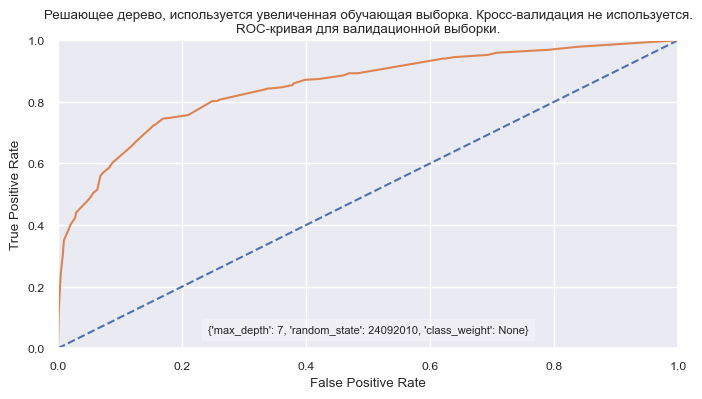

Классификатор: DecisionTreeClassifier()
Решающее дерево, используется увеличенная обучающая выборка. Кросс-валидация не используется.

Подобранные гиперпараметры: {'max_depth': 7, 'random_state': 24092010, 'class_weight': None}
Использование кросс-валидации при обучении: False

Для валидационной выборки достигнута максимальная F1-мера 0.628 при пороге 0.600.
Основные метрики:


,Train,Validation
Accuracy,0.8046,0.8130
Precision,0.8213,0.5397
Recall,0.7737,0.7452
F1-Score,0.7968,0.6260
ROC-AUC,0.8901,0.8505


*******************************************************************************************



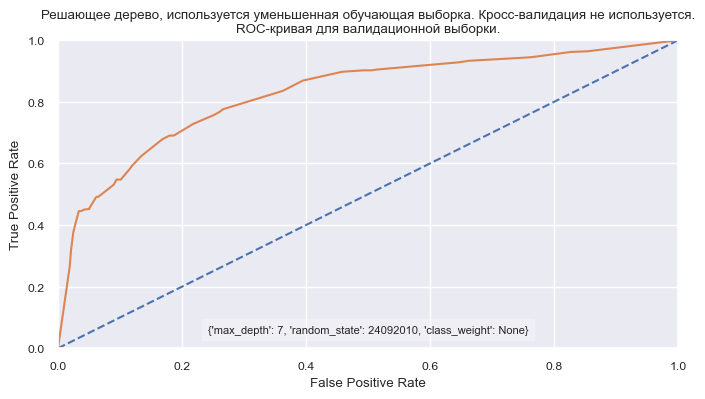

Классификатор: DecisionTreeClassifier()
Решающее дерево, используется уменьшенная обучающая выборка. Кросс-валидация не используется.

Подобранные гиперпараметры: {'max_depth': 7, 'random_state': 24092010, 'class_weight': None}
Использование кросс-валидации при обучении: False

Для валидационной выборки достигнута максимальная F1-мера 0.587 при пороге 0.500.
Основные метрики:


,Train,Validation
Accuracy,0.8153,0.7995
Precision,0.8573,0.5172
Recall,0.7522,0.6786
F1-Score,0.8013,0.5870
ROC-AUC,0.8978,0.8265


*******************************************************************************************

Найденная лучшая модель на основе решающего дерева:
F1-мера:		 0.6259999999999999
Описание:		 Решающее дерево, используется увеличенная обучающая выборка. Кросс-валидация не используется.
Параметры:		 {'max_depth': 7, 'random_state': 24092010, 'class_weight': None}


In [35]:
(dcf_best_model, dcf_best_params, dcf_best_f1, dcf_best_threshold, dcf_best_model_description) = test_models_set(models_to_test)

print ('Найденная лучшая модель на основе решающего дерева:')
print ('F1-мера:\t\t',   dcf_best_f1)
print ('Описание:\t\t',  dcf_best_model_description)
print ('Параметры:\t\t', dcf_best_params)

### Случайный лес

In [36]:
models_to_test = [
    {
        'classifier'      : RandomForestClassifier(),
        'description'     :'Случайный лес, без учета дисбаланса классов. Используется кросс-валидация.',
        'parametrs'       : {'max_depth': range(1,25,1), 'n_estimators': range(5,50,1), 'criterion': ['gini'], 'random_state':[rnd_seed]},
        'features_t'      : features.train,
        'target_t'        : target.train,
        'use_grid_search' : True
    },
    {
        'classifier'      : RandomForestClassifier(),
        'description'     :'Случайный лес, используется взвешивание классов. Используется кросс-валидация.',
        'parametrs'       : {'max_depth': range(1,25,1), 'n_estimators': range(5,50,1), 'criterion': ['gini'], 'random_state':[rnd_seed], 'class_weight':['balanced']},
        'features_t'      : features.train,
        'target_t'        : target.train,
        'use_grid_search' : True
    },
    {
        'classifier'      : RandomForestClassifier(),
        'description'     :'Случайный лес, используется взвешивание классов. Кросс-валидация не используется.',
        'parametrs'       : {'max_depth': range(1,25,1), 'n_estimators': range(5,50,1), 'criterion': ['gini'], 'random_state':[rnd_seed], 'class_weight':['balanced']},
        'features_t'      : features.train,
        'target_t'        : target.train,
        'use_grid_search' : False
    },
    {
        'classifier'      : RandomForestClassifier(),
        'description'     :'Случайный лес, используется увеличенная обучающая выборка. Кросс-валидация не используется.',
        'parametrs'       : {'max_depth': range(1,25,1), 'n_estimators': range(5,50,1), 'criterion': ['gini'], 'random_state':[rnd_seed]},
        'features_t'      : features.train_upsampled,
        'target_t'        : target.train_upsampled,
        'use_grid_search' : False
    },
    {
        'classifier'      : RandomForestClassifier(),
        'description'     :'Случайный лес, используется уменьшенная обучающая выборка. Кросс-валидация не используется.',
        'parametrs'       : {'max_depth': range(1,25,1), 'n_estimators': range(5,50,1), 'criterion': ['gini'], 'random_state':[rnd_seed]},
        'features_t'      : features.train_downsampled,
        'target_t'        : target.train_downsampled,
        'use_grid_search' : False
    }
]

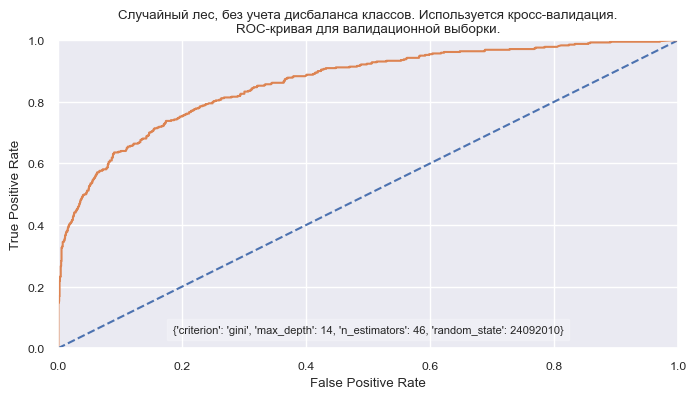

Классификатор: RandomForestClassifier()
Случайный лес, без учета дисбаланса классов. Используется кросс-валидация.

Подобранные гиперпараметры: {'criterion': 'gini', 'max_depth': 14, 'n_estimators': 46, 'random_state': 24092010}
Использование кросс-валидации при обучении: True

Для валидационной выборки достигнута максимальная F1-мера 0.643 при пороге 0.330.
Основные метрики:


,Train,Validation
Accuracy,0.9750,0.8615
Precision,0.9971,0.7698
Recall,0.8756,0.4857
F1-Score,0.9324,0.5956
ROC-AUC,0.9993,0.8619


*******************************************************************************************



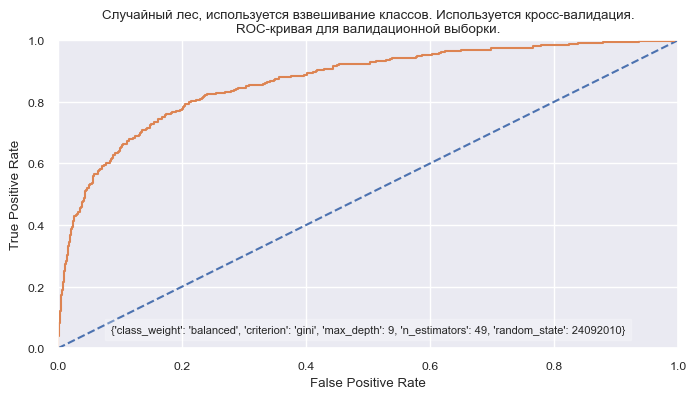

Классификатор: RandomForestClassifier()
Случайный лес, используется взвешивание классов. Используется кросс-валидация.

Подобранные гиперпараметры: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9, 'n_estimators': 49, 'random_state': 24092010}
Использование кросс-валидации при обучении: True

Для валидационной выборки достигнута максимальная F1-мера 0.643 при пороге 0.486.
Основные метрики:


,Train,Validation
Accuracy,0.9043,0.8470
Precision,0.7259,0.6351
Recall,0.8256,0.6381
F1-Score,0.7725,0.6366
ROC-AUC,0.9545,0.8669


*******************************************************************************************



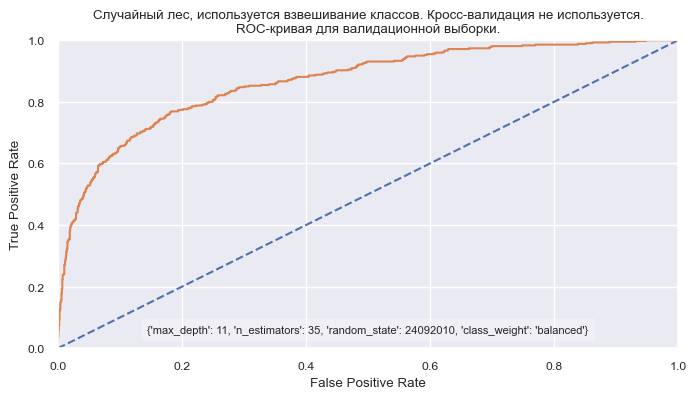

Классификатор: RandomForestClassifier()
Случайный лес, используется взвешивание классов. Кросс-валидация не используется.

Подобранные гиперпараметры: {'max_depth': 11, 'n_estimators': 35, 'random_state': 24092010, 'class_weight': 'balanced'}
Использование кросс-валидации при обучении: False

Для валидационной выборки достигнута максимальная F1-мера 0.645 при пороге 0.497.
Основные метрики:


,Train,Validation
Accuracy,0.9543,0.8630
Precision,0.8713,0.7074
Recall,0.9007,0.5929
F1-Score,0.8858,0.6451
ROC-AUC,0.9884,0.8659


*******************************************************************************************



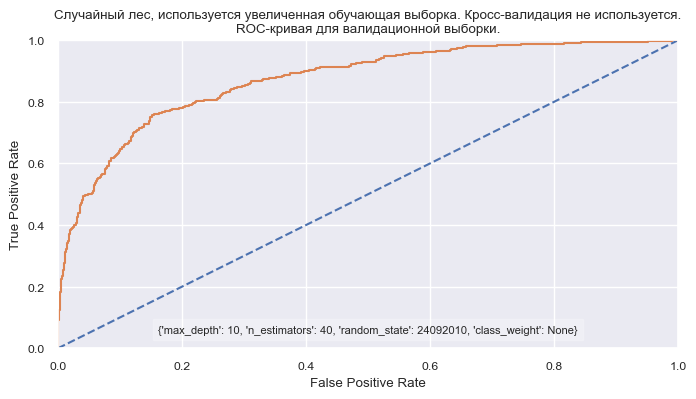

Классификатор: RandomForestClassifier()
Случайный лес, используется увеличенная обучающая выборка. Кросс-валидация не используется.

Подобранные гиперпараметры: {'max_depth': 10, 'n_estimators': 40, 'random_state': 24092010, 'class_weight': None}
Использование кросс-валидации при обучении: False

Для валидационной выборки достигнута максимальная F1-мера 0.650 при пороге 0.457.
Основные метрики:


,Train,Validation
Accuracy,0.9194,0.8415
Precision,0.9192,0.6066
Recall,0.9180,0.6976
F1-Score,0.9186,0.6489
ROC-AUC,0.9786,0.8713


*******************************************************************************************



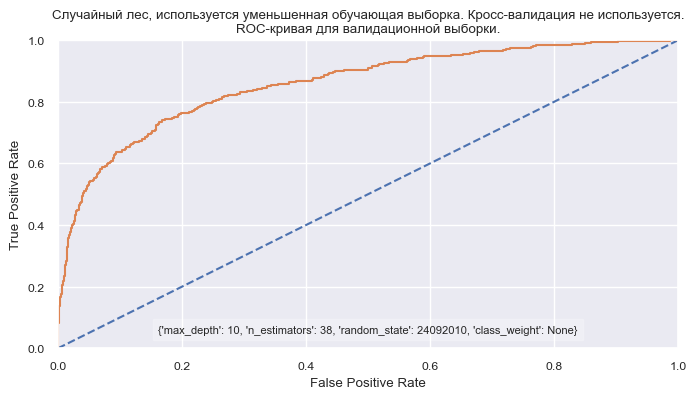

Классификатор: RandomForestClassifier()
Случайный лес, используется уменьшенная обучающая выборка. Кросс-валидация не используется.

Подобранные гиперпараметры: {'max_depth': 10, 'n_estimators': 38, 'random_state': 24092010, 'class_weight': None}
Использование кросс-валидации при обучении: False

Для валидационной выборки достигнута максимальная F1-мера 0.639 при пороге 0.606.
Основные метрики:


,Train,Validation
Accuracy,0.9440,0.8150
Precision,0.9630,0.5442
Recall,0.9223,0.7333
F1-Score,0.9422,0.6247
ROC-AUC,0.9890,0.8579


*******************************************************************************************

Найденная лучшая модель на основе случайного леса:
F1-мера:		 0.6489479512735327
Описание:		 Случайный лес, используется увеличенная обучающая выборка. Кросс-валидация не используется.
Параметры:		 {'max_depth': 10, 'n_estimators': 40, 'random_state': 24092010, 'class_weight': None}


In [37]:
(rfc_best_model, rfc_best_params, rfc_best_f1, rfc_best_threshold, rfc_best_model_description) = test_models_set(models_to_test)

print ('Найденная лучшая модель на основе случайного леса:')
print ('F1-мера:\t\t',   rfc_best_f1)
print ('Описание:\t\t',  rfc_best_model_description)
print ('Параметры:\t\t', rfc_best_params)

### Логистическая регрессия

In [38]:
models_to_test = [
    {
        'classifier'      : LogisticRegression(),
        'description'     :'Логистическая регрессия, без учета дисбаланса классов. Используется кросс-валидация.',
        'parametrs'       : {'C': np.arange(0.5,2,0.1), 'solver': ['liblinear', 'saga'], 'max_iter': range(5,50), 'random_state':[rnd_seed]},
        'features_t'      : features.train,
        'target_t'        : target.train,
        'use_grid_search' : True
    },
    {
        'classifier'      : LogisticRegression(),
        'description'     :'Логистическая регрессия, используется взвешивание классов. Используется кросс-валидация.',
        'parametrs'       : {'C': np.arange(0.5,2,0.1), 'solver': ['liblinear', 'saga'], 'max_iter': range(5,50), 'random_state':[rnd_seed], 'class_weight':['balanced']},
        'features_t'      : features.train,
        'target_t'        : target.train,
        'use_grid_search' : True
    },
    {
        'classifier'      : LogisticRegression(),
        'description'     :'Логистическая регрессия, используется взвешивание классов. Кросс-валидация не используется.',
        'parametrs'       : {'C': np.arange(0.5,2,0.1), 'solver': ['liblinear', 'saga'], 'max_iter': range(5,50), 'random_state':[rnd_seed], 'class_weight':['balanced']},
        'features_t'      : features.train,
        'target_t'        : target.train,
        'use_grid_search' : False
    },
    {
        'classifier'      : LogisticRegression(),
        'description'     :'Логистическая регрессия, используется увеличенная обучающая выборка. Кросс-валидация не используется.',
        'parametrs'       : {'C': np.arange(0.5,2,0.1), 'solver': ['liblinear', 'saga'], 'max_iter': range(5,50), 'random_state':[rnd_seed]},
        'features_t'      : features.train_upsampled,
        'target_t'        : target.train_upsampled,
        'use_grid_search' : False
    },
    {
        'classifier'      : LogisticRegression(),
        'description'     :'Логистическая регрессия, используется уменьшенная обучающая выборка. Кросс-валидация не используется.',
        'parametrs'       : {'C': np.arange(0.5,2,0.1), 'solver': ['liblinear', 'saga'], 'max_iter': range(5,50), 'random_state':[rnd_seed]},
        'features_t'      : features.train_downsampled,
        'target_t'        : target.train_downsampled,
        'use_grid_search' : False
    }
]

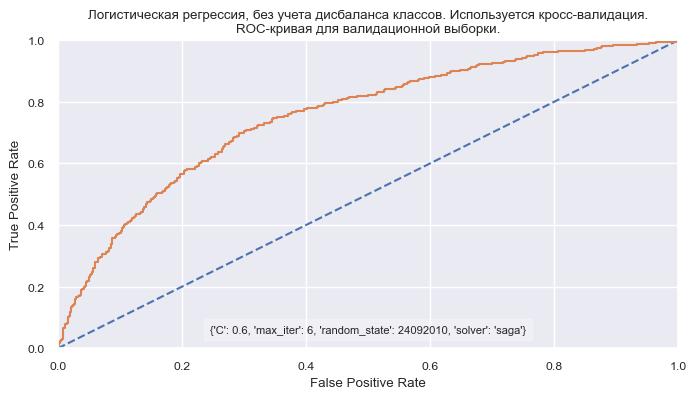

Классификатор: LogisticRegression()
Логистическая регрессия, без учета дисбаланса классов. Используется кросс-валидация.

Подобранные гиперпараметры: {'C': 0.6, 'max_iter': 6, 'random_state': 24092010, 'solver': 'saga'}
Использование кросс-валидации при обучении: True

Для валидационной выборки достигнута максимальная F1-мера 0.498 при пороге 0.191.
Основные метрики:


,Train,Validation
Accuracy,0.8266,0.7970
Precision,0.6391,0.5412
Recall,0.2737,0.2190
F1-Score,0.3833,0.3119
ROC-AUC,0.7900,0.7525


*******************************************************************************************



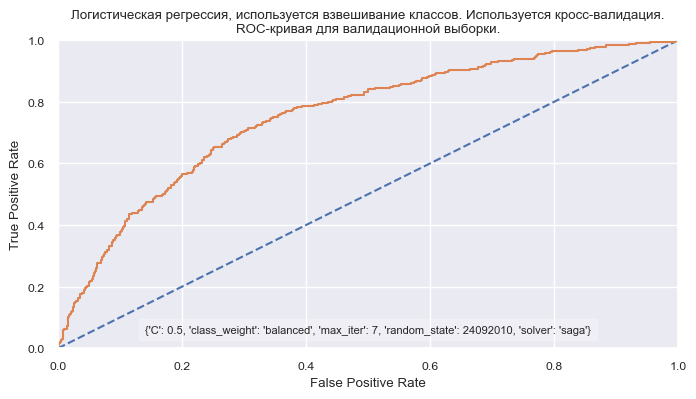

Классификатор: LogisticRegression()
Логистическая регрессия, используется взвешивание классов. Используется кросс-валидация.

Подобранные гиперпараметры: {'C': 0.5, 'class_weight': 'balanced', 'max_iter': 7, 'random_state': 24092010, 'solver': 'saga'}
Использование кросс-валидации при обучении: True

Для валидационной выборки достигнута максимальная F1-мера 0.501 при пороге 0.513.
Основные метрики:


,Train,Validation
Accuracy,0.7335,0.7175
Precision,0.3994,0.3966
Recall,0.7029,0.6619
F1-Score,0.5094,0.4960
ROC-AUC,0.7911,0.7544


*******************************************************************************************



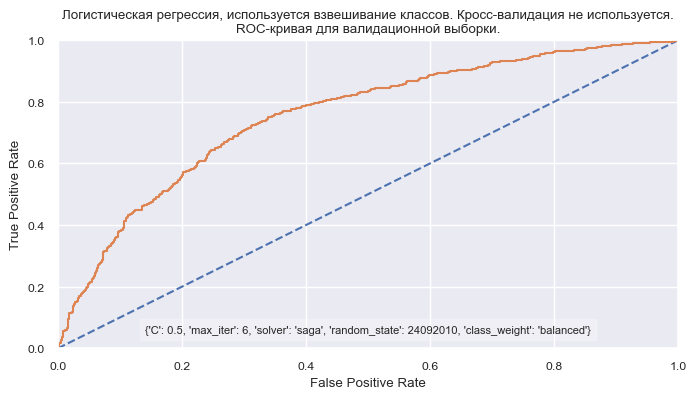

Классификатор: LogisticRegression()
Логистическая регрессия, используется взвешивание классов. Кросс-валидация не используется.

Подобранные гиперпараметры: {'C': 0.5, 'max_iter': 6, 'solver': 'saga', 'random_state': 24092010, 'class_weight': 'balanced'}
Использование кросс-валидации при обучении: False

Для валидационной выборки достигнута максимальная F1-мера 0.500 при пороге 0.523.
Основные метрики:


,Train,Validation
Accuracy,0.7324,0.7185
Precision,0.3985,0.3986
Recall,0.7055,0.6690
F1-Score,0.5094,0.4996
ROC-AUC,0.7912,0.7553


*******************************************************************************************



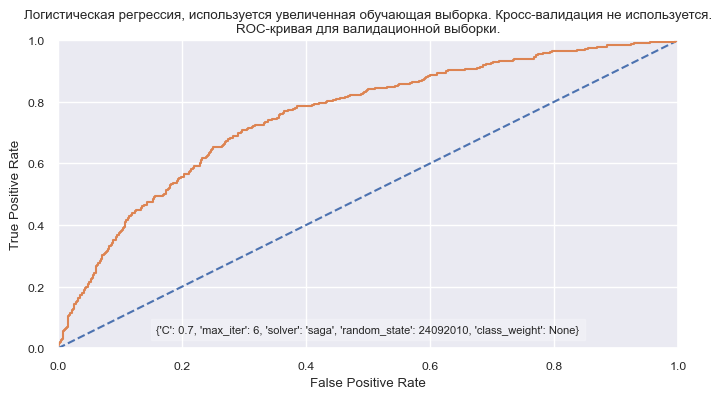

Классификатор: LogisticRegression()
Логистическая регрессия, используется увеличенная обучающая выборка. Кросс-валидация не используется.

Подобранные гиперпараметры: {'C': 0.7, 'max_iter': 6, 'solver': 'saga', 'random_state': 24092010, 'class_weight': None}
Использование кросс-валидации при обучении: False

Для валидационной выборки достигнута максимальная F1-мера 0.502 при пороге 0.518.
Основные метрики:


,Train,Validation
Accuracy,0.7239,0.7170
Precision,0.7271,0.3969
Recall,0.7081,0.6690
F1-Score,0.7175,0.4982
ROC-AUC,0.7912,0.7544


*******************************************************************************************



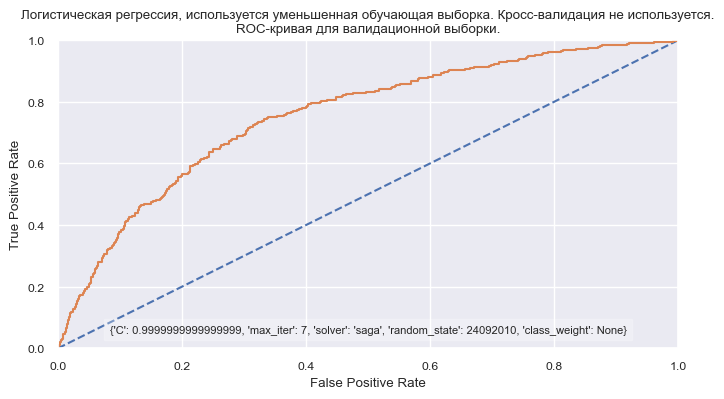

Классификатор: LogisticRegression()
Логистическая регрессия, используется уменьшенная обучающая выборка. Кросс-валидация не используется.

Подобранные гиперпараметры: {'C': 0.9999999999999999, 'max_iter': 7, 'solver': 'saga', 'random_state': 24092010, 'class_weight': None}
Использование кросс-валидации при обучении: False

Для валидационной выборки достигнута максимальная F1-мера 0.500 при пороге 0.518.
Основные метрики:


,Train,Validation
Accuracy,0.7161,0.7170
Precision,0.7186,0.3960
Recall,0.7012,0.6619
F1-Score,0.7098,0.4955
ROC-AUC,0.7868,0.7540


*******************************************************************************************

Найденная лучшая модель на основе логистической регрессии:
F1-мера:		 0.4995555555555556
Описание:		 Логистическая регрессия, используется взвешивание классов. Кросс-валидация не используется.
Параметры:		 {'C': 0.5, 'max_iter': 6, 'solver': 'saga', 'random_state': 24092010, 'class_weight': 'balanced'}


In [39]:
simplefilter("ignore", category=ConvergenceWarning)
(lr_best_model, lr_best_params, lr_best_f1, lr_best_threshold, lr_best_model_description) = test_models_set(models_to_test)

print ('Найденная лучшая модель на основе логистической регрессии:')
print ('F1-мера:\t\t',   lr_best_f1)
print ('Описание:\t\t',  lr_best_model_description)
print ('Параметры:\t\t', lr_best_params)

### Выводы по разделу

* Исследованы 3 классификатора: Решающее дерево, Случайный лес и Логистическая регрессия. Каждый классификатор обучался на выборке с дисбалансом классов, на увеличенной и уменьшенной сбалансированной выборке, а также применялся механизм взвешивания классов.

* Для Решающего дерева и Случайного леса более высокая F1-метрика была у моделей, которые обучены на увеличенной выборке без использования кросс-валидации. Для Логистической регрессии лучший результат показала модель, обученная с использованием взвешивания классов и также без использования кросс-валидации.

* Наилучшей моделью по критерию максимальной F1-метрики на валидационной выборке определен следующий классификатор: `RandomForestClassifier(max_depth=10, n_estimators=40, random_state=24092010, criterio='gini', 'class_weight': None)`, F1-мера на валидационной выборке: `0.6489`. При изменении порога классификации на значение `0.457` удалось достичь F1-меры `0.650`. Обучение данной модели проводилось на увеличенной выборке без использования кросс-валидации.

## Тестирование модели

In [40]:
def test_model(model,features,target,threshold=0.5):
    print ('Выбрана лучшая модель:\t',model)
    print ('Порог классификации:\t',threshold)
    predicted = model.predict_proba(features)[:,1] > threshold
    
    print(f'Accuracy:  \t{accuracy_score(target, predicted):.3f}')
    print(f'Recall:    \t{recall_score(target, predicted):.3f}')
    print(f'Precision: \t{precision_score(target, predicted):.3f}')
    print(f'F1-мера:   \t{f1_score(target, predicted):.3f}')
    print(f'ROC_AUC:   \t{roc_auc_score(target, model.predict_proba(features)[:,1]):.3f}')

    fpr, tpr, thresholds = roc_curve(target, model.predict_proba(features)[:,1])
    plt.figure(figsize=(8, 4))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.text(0.5,0.05, model, bbox = dict(facecolor = 'white', alpha = 0.25), fontsize = 8, horizontalalignment='center')
    show_plot_labels('ROC-кривая для тестовой выборки','False Positive Rate','True Positive Rate')



Метрики на тестовой выборке:
Выбрана лучшая модель:	 RandomForestClassifier(max_depth=10, n_estimators=40, random_state=24092010)
Порог классификации:	 0.45738146371519706
Accuracy:  	0.807
Recall:    	0.722
Precision: 	0.529
F1-мера:   	0.611
ROC_AUC:   	0.851


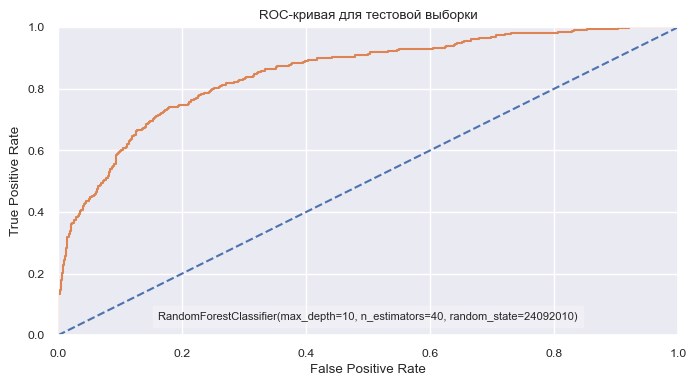

In [41]:
print ('\nМетрики на тестовой выборке:')
test_model(rfc_best_model,features.test,target.test,rfc_best_threshold)

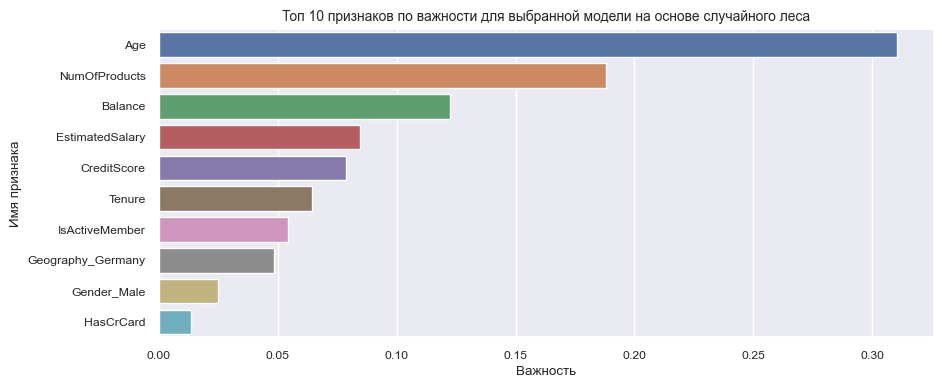

In [42]:
feature_importances_df = pd.DataFrame({
    "Feature Name": features.test.columns,
    "Importance": rfc_best_model.feature_importances_
})
feature_importances_df = feature_importances_df.sort_values(by="Importance", ascending=False).head(10)

plt.figure(figsize=(10,4))
sb.barplot(data=feature_importances_df, x='Importance', y='Feature Name')
plt.title('Топ 10 признаков по важности для выбранной модели на основе случайного леса', fontsize=10)
plt.xlabel('Важность')
plt.ylabel('Имя признака')
plt.show()

### Выводы по разделу

* Выбранная модель показала следующие результаты на тестовой выборке: 
    * `Accuracy: 0.807`
    * `Recall: 0.722`
    * `Precision: 0.529`
    * `F1-мера: 0.611`
    * `ROC_AUC: 0.851`
</br></br>
* Довольно высокое значение метрик F1 и ROC_AUC показывает, что модель является адекватной и показывает значительно лучшие результаты чем случайная модель предсказаний.

* Наиболее важными признаками для предсказания оказались: возраст клиента, число используемых продуктов банка, баланс на счету, предполагаемый доход, кредитный рейтинг, признак активности клиента и как долго клиент пользуется услугами банка.

## Общий вывод

1. Основной целью данной работы является выбор и обучение модели, которая по данным о клиенте сможет прогнозировать, уйдёт ли клиент из банка в ближайшее время;

2. Для выполнения проекта представлены исторические данные о поведении клиентов и расторжении договоров с банком. Датасет содержит 10000 строк (явные дубликаты отсутствуют) и следующие столбцы:

* `RowNumber` — индекс строки в данных;
* `CustomerId` — уникальный идентификатор клиента;
* `Surname` — фамилия;
* `CreditScore` — кредитный рейтинг;
* `Geography` — страна проживания;
* `Gender` — пол;
* `Age` — возраст;
* `Tenure` — сколько лет человек является клиентом банка;
* `Balance` — баланс на счёте;
* `NumOfProducts` — количество продуктов банка, используемых клиентом;
* `HasCrCard` — наличие кредитной карты;
* `IsActiveMember` — активность клиента;
* `EstimatedSalary` — предполагаемая зарплата;
* `Exited` — факт ухода клиента;

3. Выполнена предобработка данных и краткий исследовательский анализ:

* В датасете не обнаружены неявные дубликаты;

* Столбцы `RowNumber`, `CustomerId`, `Surname` удалены из датасета, т.к. не будут полезны для обучения модели;

* В столбце `Tenure` обнаружены пропуски. Для их заполнения построена и обучена регрессионная модель, которая прогнозирует значение `Tenure` для клиента. R2-метрика модели положительная, но к сожалению близка к 0. Модель предсказывает значения довольно близкие к медианному значению столбца `5 лет`. Однако распределение клиентов по длительности использования услуг банка оказывается более равномерным в области 4-6 лет, нежели при заполнении пропусков медианным или средним значением.

* В столбцах `CreditScore`, `Age` и `NumOfProducts` обнаружены аномальные значения. Эти значения не используются при построении обучающей выборки. 

4. Созданы обучающая, валидационная и тестовая выбороки:

* Для обучения модели в качестве целевого признака выбрано значение столбца `Exited`;

* Датасет разбит на три выборки в пропорции `3:1:1` - обучающая (5883 наблюдений), валидационная (2000 наблюдения) и тестовая (2000 наблюдений).

* В обучающей выборке обнаружен дисбаланс классов приблизительно в пропорции `5:1`. Для исследования методов подавления дисбаланса построены увеличенная и уменьшенная обучающая выборка, в которых пропорция классов близка к `1:1`.

* К обучающей выборке применен механизм масштабирования количественных признаков и OHE кодирование категориальных признаков.

* Произведена очистка обучающей выборки от аномальных значений признаков `Age`, `NumOfProducts` и `CreditScore`.

5. Выполнен выбор модели:

* Исследованы 3 классификатора: Решающее дерево, Случайный лес и Логистическая регрессия. Каждый классификатор обучался на выборке с дисбалансом классов, на увеличенной и уменьшенной сбалансированной выборке, а также применялся механизм взвешивания классов.

* Для Решающего дерева и Случайного леса более высокая F1-метрика была у моделей, которые обучены на увеличенной выборке без использования кросс-валидации. Для Логистической регрессии лучший результат показала модель, обученная с использованием взвешивания классов и также без использования кросс-валидации.

* Наилучшей моделью по критерию максимальной F1-метрики на валидационной выборке определен следующий классификатор: `RandomForestClassifier(max_depth=10, n_estimators=40, random_state=24092010, criterio='gini', 'class_weight': None)`, F1-мера на валидационной выборке: `0.6489`. При изменении порога классификации на значение `0.457` удалось достичь F1-меры `0.650`. Обучение данной модели проводилось на увеличенной выборке без использования кросс-валидации.

6. Выполнено тестирование модели:

* Выбранная модель показала следующие результаты на тестовой выборке: 
    * `Accuracy: 0.807`
    * `Recall: 0.722`
    * `Precision: 0.529`
    * `F1-мера: 0.611`
    * `ROC_AUC: 0.851`
</br></br>
* Довольно высокое значение метрик F1 и ROC_AUC показывает, что модель является адекватной и показывает значительно лучшие результаты чем случайная модель предсказаний.

* Наиболее важными признаками для предсказания оказались: возраст клиента, число используемых продуктов банка, баланс на счету, предполагаемый доход, кредитный рейтинг, признак активности клиента и как долго клиент пользуется услугами банка.